In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt

from dispersant_screener.utils import get_maxmin_samples, get_hypervolume, read_pickle, get_random_exploration_bl, is_pareto_efficient
from dispersant_screener.definitions import FEATURES
from sklearn.preprocessing import StandardScaler
from glob import glob 
import os

DATADIR = '../data'
from functools import partial
from matplotlib import animation, rc

COLORS = [
    "#ffbe0b", 
    "#fb5607", 
    "#ff006e",
    "#3a86ff", 
]

plt.rcParams['font.family'] = 'sans-serif'

In [2]:
discarded = np.load('../work/sweeps3/20201024-160845_missing_data_0.01_0.05_0.05_60-discarded.npy', allow_pickle=True)
unclassified = np.load('../work/sweeps3/20201024-160845_missing_data_0.01_0.05_0.05_60-unclassified.npy', allow_pickle=True)
pareto_optimal = np.load('../work/sweeps3/20201024-160845_missing_data_0.01_0.05_0.05_60-pareto_optimal_indices.npy', allow_pickle=True)
selected = np.load('../work/sweeps3/20201024-160845_missing_data_0.01_0.05_0.05_60-selected.npy', allow_pickle=True)
greedy_indices = np.load('../work/sweeps3/20201024-160845_missing_data_0.01_0.05_0.05_60-greedy_indices.npy', allow_pickle=True)

In [3]:
discarded1 = np.load('../work/sweeps3/20201024-160845_missing_data_0.1_0.05_0.05_60-discarded.npy', allow_pickle=True)
unclassified1 = np.load('../work/sweeps3/20201024-160845_missing_data_0.1_0.05_0.05_60-unclassified.npy', allow_pickle=True)
pareto_optimal1 = np.load('../work/sweeps3/20201024-160845_missing_data_0.1_0.05_0.05_60-pareto_optimal_indices.npy', allow_pickle=True)
selected1 = np.load('../work/sweeps3/20201024-160845_missing_data_0.1_0.05_0.05_60-selected.npy', allow_pickle=True)
greedy_indices1 = np.load('../work/sweeps3/20201024-160845_missing_data_0.1_0.05_0.05_60-greedy_indices.npy', allow_pickle=True)

In [18]:
discarded2 = np.load('../work/sweeps3/20201024-160845_missing_data_0.05_0.05_0.05_60-discarded.npy', allow_pickle=True)
unclassified2 = np.load('../work/sweeps3/20201024-160845_missing_data_0.05_0.05_0.05_60-unclassified.npy', allow_pickle=True)
pareto_optimal2 = np.load('../work/sweeps3/20201024-160845_missing_data_0.05_0.05_0.05_60-pareto_optimal_indices.npy', allow_pickle=True)
selected2 = np.load('../work/sweeps3/20201024-160845_missing_data_0.05_0.05_0.05_60-selected.npy', allow_pickle=True)
greedy_indices2 = np.load('../work/sweeps3/20201024-160845_missing_data_0.05_0.05_0.05_60-greedy_indices.npy', allow_pickle=True)

In [4]:
def get_summary_stats_time(pareto_optimal=pareto_optimal, discarded=discarded, selected=selected, unclassified=unclassified): 
    pareto_points = []
    non_pareto_points = []
    sampled_points = []
    unclassified_points = []
    
    for array in pareto_optimal:
        pareto_points.append(len(array))
        
    for array in discarded:
        non_pareto_points.append(len(array))
    
    for array in selected:
        sampled_points.append(len(array))
        
    for array in unclassified: 
        unclassified_points.append(len(array))
    
    return pareto_points, non_pareto_points, sampled_points, unclassified_points

In [5]:
pareto_points, non_pareto_points, sampled_points, unclassified_points = get_summary_stats_time()

In [6]:
pareto_points1, non_pareto_points1, sampled_points1, unclassified_points1 = get_summary_stats_time(
    pareto_optimal1, discarded1, selected1, unclassified1
)

In [19]:
pareto_points2, non_pareto_points2, sampled_points2, unclassified_points2 = get_summary_stats_time(
    pareto_optimal2, discarded2, selected2, unclassified2
)

In [7]:
def load_data(n_samples, label_scaling: bool = False):
    """Take in Brian's data and spit out some numpy arrays for the PAL"""
    df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
    a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
    deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values  # pylint:disable=unused-variable
    gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values * (-1)
    gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
    force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values  # pylint:disable=unused-variable
    rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
    y = np.hstack([rg.reshape(-1, 1), gibbs.reshape(-1, 1), gibbs_max.reshape(-1, 1)])
    assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

    feat_scaler = StandardScaler()
    X = feat_scaler.fit_transform(df_full_factorial_feat)

    if label_scaling:
        label_scaler = MinMaxScaler()
        y = label_scaler.fit_transform(y)

    #greedy_indices = get_maxmin_samples(X, n_samples)

    return X, y#, greedy_indice

In [8]:
X, y = load_data(1)

In [20]:
hvs = [get_hypervolume(y[po], [5,5,5]) for po in pareto_optimal]
hvs1 = [get_hypervolume(y[po], [5,5,5]) for po in pareto_optimal1]
hvs2 = [get_hypervolume(y[po], [5,5,5]) for po in pareto_optimal2]

In [10]:
hvs_padded = np.array([hvs[0]] * 60 + hvs)
hvs_padded1 = np.array([hvs1[0]] * 60 + hvs1)

In [27]:
np.save('missing_data_hv.npy', hvs1)
np.save('missing_data_hv0.npy', hvs)

In [11]:
REFERENCE_HV = get_hypervolume(y, [5,5,5])

In [12]:
random_explorations = np.load('random_exploration_60_init.npy')
random_exploration_median = np.median(random_explorations, axis=0)
random_exploration_std = np.std(random_explorations, axis=0)

/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two mi

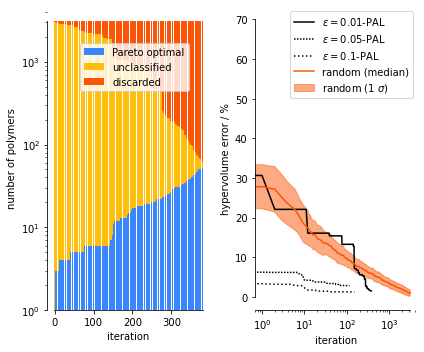

In [26]:
fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(6,5))
ax[0].bar(range(len(pareto_optimal)), 
          pareto_points,
          label='Pareto optimal', color=COLORS[3])
ax[0].bar(range(len(pareto_optimal)), unclassified_points, bottom=np.array(pareto_points), 
          label='unclassified', color=COLORS[0])
ax[0].bar(range(len(pareto_optimal)), non_pareto_points, 
          bottom=unclassified_points+np.array(pareto_points), label='discarded', color=COLORS[1])



ax[0].set_xlabel('iteration (after initialization)')
ax[1].set_xlabel('iteration (including initialization)')
ax[0].set_ylabel('number of polymers')
ax[1].set_ylabel('hypervolume error / %')

ax[0].spines['left'].set_smart_bounds(True)
ax[0].spines['bottom'].set_smart_bounds(True)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].spines['left'].set_smart_bounds(True)
ax[1].spines['bottom'].set_smart_bounds(True)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[1].plot((REFERENCE_HV-np.array(hvs))/REFERENCE_HV * 100, label=r'$\epsilon=0.01$-PAL', c='black')
ax[1].plot((REFERENCE_HV-np.array(hvs2))/REFERENCE_HV * 100, label=r'$\epsilon=0.05$-PAL', c='black', ls=(0, (1, 1)))
ax[1].plot((REFERENCE_HV-np.array(hvs1))/REFERENCE_HV * 100, label=r'$\epsilon=0.1$-PAL', c='black', ls='dotted')

ax[1].plot((REFERENCE_HV-np.array(random_exploration_median))/REFERENCE_HV * 100, 
           label='random (median)', c=COLORS[1])
ax[1].fill_between(np.arange(len(y)),
                   (REFERENCE_HV-np.array(random_exploration_median + random_exploration_std))/REFERENCE_HV * 100, (REFERENCE_HV-np.array(random_exploration_median - random_exploration_std))/REFERENCE_HV * 100, 
                   label=r'random (1 $\sigma$)', color=COLORS[1], alpha=.5)
#ax[1].plot(ratios)

ax[0].legend(loc='right', bbox_to_anchor=(0.9,0.8))

ax[1].set_xscale('log')
ax[0].set_yscale('log')
ax[1].legend(loc='upper right')


ax[0].set_xlabel('iteration')
ax[1].set_xlabel('iteration')

fig.tight_layout()
fig.savefig('missing_data.pdf', bbox_inches='tight')